In [2]:
import matplotlib as plt
import pandas as pd
import requests
import seaborn
import glob
import statsmodels.api as sm
from datetime import date
import numpy as np

In [3]:
sectors = ['banks']#'fmcg','pharma','housing']

In [35]:
training = []
testing = []
avg = []

In [5]:
def date_index(data,year):
    index = data['Date'].str.find(year)
    return index

In [6]:
pairs = []
for name in sectors:
    list_of_companies = glob.glob(name+'/*.csv')
    n = len(list_of_companies)
    for i in range(n):
        print(i)
        for j in range(i+1, n):
            print(j)
            pairs.append((list_of_companies[i],list_of_companies[j]))

0
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
2
3
4
5
6
7
8
9
3
4
5
6
7
8
9
4
5
6
7
8
9
5
6
7
8
9
6
7
8
9
7
8
9
8
9
9


In [7]:
print(pairs[-2])

('banks\\KOTAKBANK.csv', 'banks\\SBIN.csv')


In [8]:
print(pairs.index(('banks\\HDFCBANK.csv', 'banks\\SBIN.csv')))

29


In [34]:
def trade1(name1, name2,window):
    S1 = ((pd.read_csv(name1)).interpolate(axis=0))['Adj Close'][-300:]
    S2 = (pd.read_csv(name2)).interpolate(axis=0)['Adj Close'][-300:]
    window1 = window[0] + 3
    window2 = window[1] + 35
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0

    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    
   
    money = 10000
    returns = [10000]
    countS1 = 0
    countS2 = 0
    for i in zscore.index:
        # Sell short if the z-score is > 1
        if zscore[i] > 1 and (countS1==0) and (countS2==0) :
            countS1 = -(money/2)/S1[i]
            countS2 = (money/2)/S2[i]
            print(S1[i])
            print(S2[i])
            print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
            #print('Selling Ratio %s %s %s %s %s'%(money, ratios[i], countS1,countS2,zscore[i]))
        # Buy long if the z-score is < 1
        elif zscore[i] < -1 and (countS1==0) and (countS2==0):
            countS1 = (money/2)/S1[i]
            countS2 = -(money/2)/S2[i]
            print(S1[i])
            print(S2[i])
            print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
        # Clear positions if the z-score between -.5 and .5
        #elif abs(zscore[i]) < 1:
        elif abs(zscore[i]) < 0.5:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))
            print(S1[i])
            print(S2[i])
            returns.append(money)
            
          
    print('test' + str(returns[-1]))
    testing.append(returns[-1])
    return pd.Series(returns)

In [27]:
def trade(S1, S2, window1, window2):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    
    #zscore = zscore[]
    # Simulate trading
    # Start with no money and no positions
    money = 10000
    returns = []
    countS1 = 0
    countS2 = 0
    for i in zscore.index:
        # Sell short if the z-score is > 1
        if zscore[i] > 1 and (countS1==0) and (countS2==0) :
            countS1 = -(money/2)/S1[i]
            countS2 = (money/2)/S2[i]
            #print(S1[i])
            #print(S2[i])
            #print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
            #print('Selling Ratio %s %s %s %s %s'%(money, ratios[i], countS1,countS2,zscore[i]))
        # Buy long if the z-score is < 1
        elif zscore[i] < -1 and (countS1==0) and (countS2==0):
            countS1 = (money/2)/S1[i]
            countS2 = -(money/2)/S2[i]
            #print(S1[i])
            #print(S2[i])
            #print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
            #print('Buying Ratio %s %s %s %s %s'%(money,ratios[i], countS1,countS2,zscore[i]))
        # Clear positions if the z-score between -.5 and .5
        #elif abs(zscore[i]) < 1:
        elif abs(zscore[i]) < 0.5:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            #print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))
            #print(S1[i])
            #print(S2[i])
            #returns.append(money)
            
            
            #print('Exit pos %s %s %s %s %s'%(money,ratios[i], countS1,countS2,zscore[i]))
            
            
    return money

In [2]:
def optimal_window(name1,name2):
    main = []
    data1 = (pd.read_csv(name1,parse_dates = ['Date'],index_col = 'Date')).interpolate(axis=0)
    data2 = (pd.read_csv(name2,parse_dates = ['Date'],index_col = 'Date')).interpolate(axis=0)
    start_date = '20160101'
    end_date = '20181231'
    set1 = (data1[start_date:end_date])
    set2 = (data2[start_date:end_date])    
    for f in range(3,25):
        row =  [trade(set1['Adj Close'],set2['Adj Close'],f,s) for s in range(35,200)] 
        main.append(row)
    scores = np.array(main)
    windows = np.unravel_index(np.argmax(scores),shape=(22,165))
    print(np.argmax(scores))
    print(windows)
    print('training' + str(scores[windows[0],windows[1]]))
    training.append(scores[windows[0],windows[1]])
    #plt.figure.Figure(figsize=(25,25))
    #seaborn.heatmap(scores)
    cumsum = 0
    count = 1
    for i in np.nditer(scores):
        cumsum = cumsum + i
        count = count + 1
    print('Avg Return')
    print(cumsum/count)
    print(np.mean(scores))
    avg.append(np.mean(scores))
    return windows

In [ ]:
windows = []
for i in pairs:
    print(i)
    window_1 = optimal_window(i[0],i[1])
    print('----')
    trade1(i[0],i[1],window_1)
    windows.append(window_1)

('banks\\AXISBANK.csv', 'banks\\BANKBARODA.csv')


In [ ]:
df = pd.DataFrame(list(zip(training,avg,testing)), 
               columns =['Training', 'avg','testing']) 
df.to_csv('zscore_result.csv')

In [14]:
def plot_z_score(zscore):
    plt.figure.Figure(figsize=(15,7))
    zscore.plot()
    plt.pyplot.axhline(0, color='black')
    plt.pyplot.axhline(1.0, color='red', linestyle='--')
    plt.pyplot.axhline(-1.0, color='green', linestyle='--')
    plt.pyplot.axhline(0.5, color='yellow', linestyle='--')
    plt.pyplot.axhline(-0.5, color='yellow', linestyle='--')
    plt.pyplot.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
    plt.pyplot.show()


In [15]:
def plotter(name1, name2,window):
    trades = 0
    S1 = ((pd.read_csv(name1)).interpolate(axis=0))['Adj Close']
    S2 = (pd.read_csv(name2)).interpolate(axis=0)['Adj Close']
    window1 = window[0] + 3 
    window2 = window[1] + 35
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0

    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    plot_z_score(zscore)

('banks\\AXISBANK.csv', 'banks\\BANKBARODA.csv')


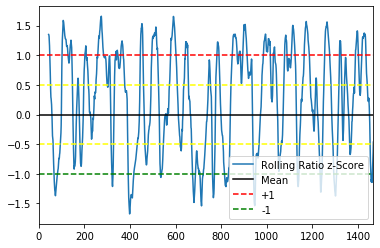

('banks\\AXISBANK.csv', 'banks\\CORPBANK.csv')


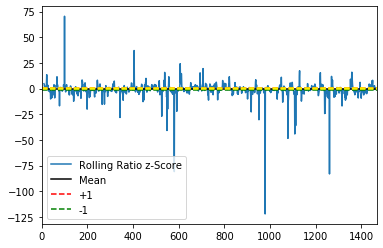

('banks\\AXISBANK.csv', 'banks\\HDFCBANK.csv')
('banks\\AXISBANK.csv', 'banks\\ICICIBANK.csv')
('banks\\AXISBANK.csv', 'banks\\INDUSINDBK.csv')


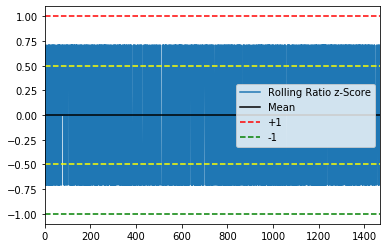

('banks\\AXISBANK.csv', 'banks\\J&KBANK.csv')
('banks\\AXISBANK.csv', 'banks\\KOTAKBANK.csv')


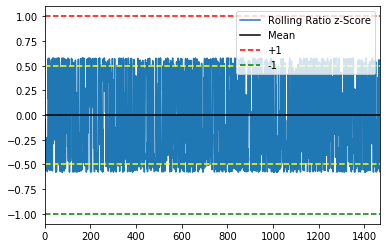

('banks\\AXISBANK.csv', 'banks\\PNB.csv')


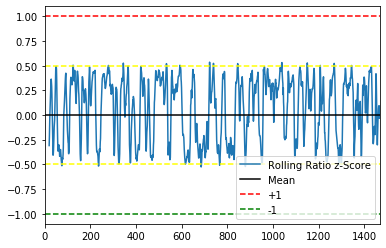

('banks\\AXISBANK.csv', 'banks\\SBIN.csv')


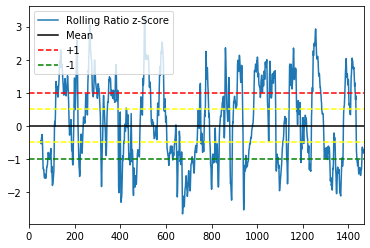

('banks\\BANKBARODA.csv', 'banks\\CORPBANK.csv')


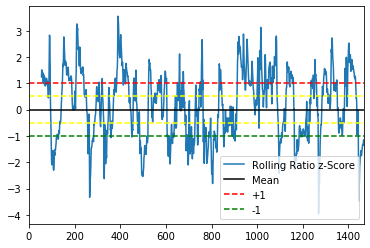

('banks\\BANKBARODA.csv', 'banks\\HDFCBANK.csv')


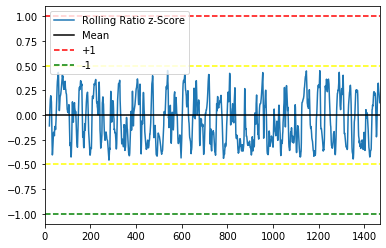

('banks\\BANKBARODA.csv', 'banks\\ICICIBANK.csv')


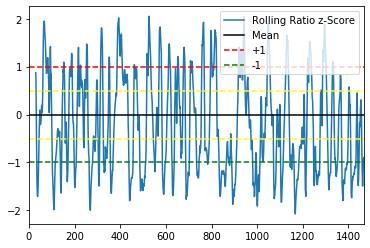

('banks\\BANKBARODA.csv', 'banks\\INDUSINDBK.csv')


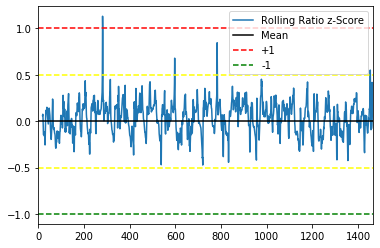

('banks\\BANKBARODA.csv', 'banks\\J&KBANK.csv')


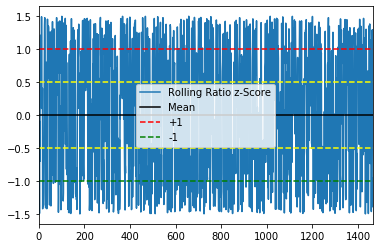

('banks\\BANKBARODA.csv', 'banks\\KOTAKBANK.csv')


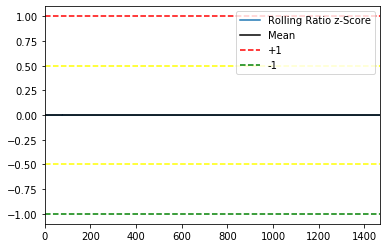

('banks\\BANKBARODA.csv', 'banks\\PNB.csv')


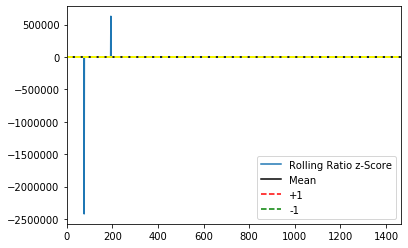

('banks\\BANKBARODA.csv', 'banks\\SBIN.csv')


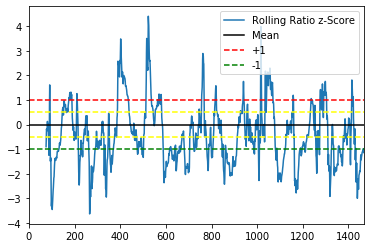

('banks\\CORPBANK.csv', 'banks\\HDFCBANK.csv')


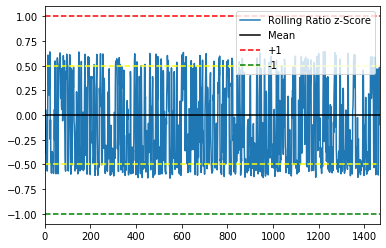

('banks\\CORPBANK.csv', 'banks\\ICICIBANK.csv')


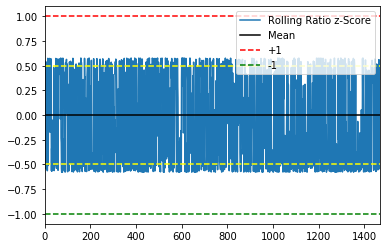

('banks\\CORPBANK.csv', 'banks\\INDUSINDBK.csv')


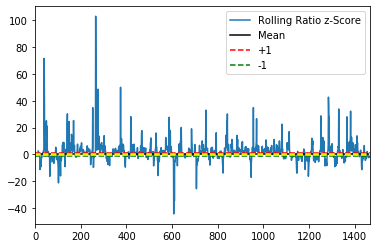

('banks\\CORPBANK.csv', 'banks\\J&KBANK.csv')
('banks\\CORPBANK.csv', 'banks\\KOTAKBANK.csv')


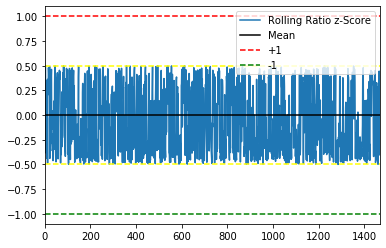

('banks\\CORPBANK.csv', 'banks\\PNB.csv')


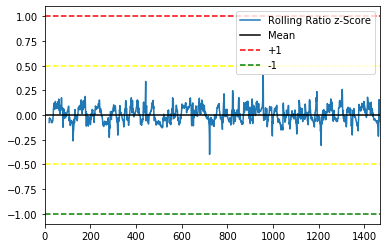

('banks\\CORPBANK.csv', 'banks\\SBIN.csv')
('banks\\HDFCBANK.csv', 'banks\\ICICIBANK.csv')
('banks\\HDFCBANK.csv', 'banks\\INDUSINDBK.csv')


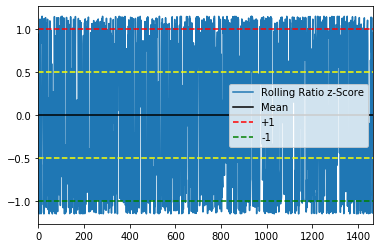

('banks\\HDFCBANK.csv', 'banks\\J&KBANK.csv')


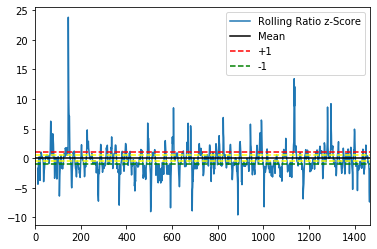

('banks\\HDFCBANK.csv', 'banks\\KOTAKBANK.csv')
('banks\\HDFCBANK.csv', 'banks\\PNB.csv')


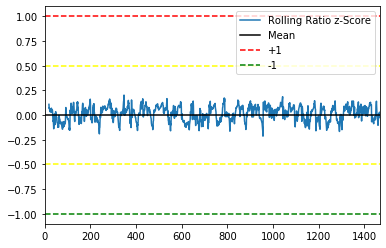

('banks\\HDFCBANK.csv', 'banks\\SBIN.csv')


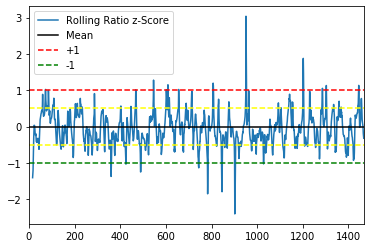

('banks\\ICICIBANK.csv', 'banks\\INDUSINDBK.csv')


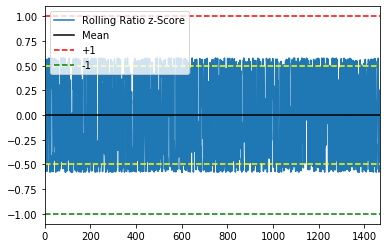

('banks\\ICICIBANK.csv', 'banks\\J&KBANK.csv')


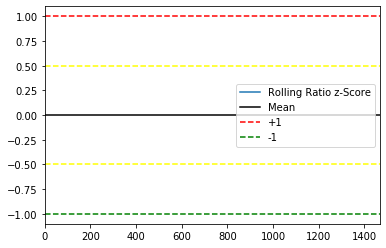

('banks\\ICICIBANK.csv', 'banks\\KOTAKBANK.csv')


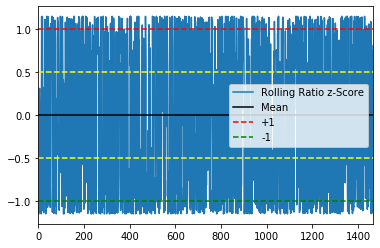

('banks\\ICICIBANK.csv', 'banks\\PNB.csv')


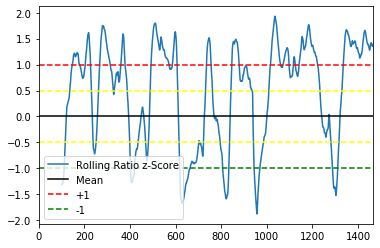

('banks\\ICICIBANK.csv', 'banks\\SBIN.csv')


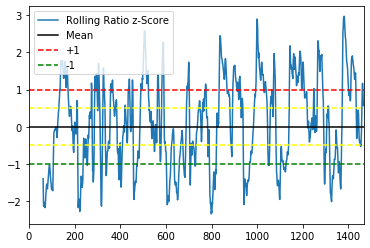

('banks\\INDUSINDBK.csv', 'banks\\J&KBANK.csv')


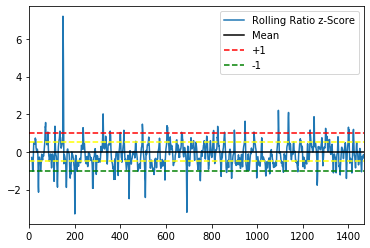

('banks\\INDUSINDBK.csv', 'banks\\KOTAKBANK.csv')


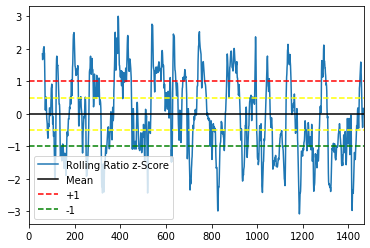

('banks\\INDUSINDBK.csv', 'banks\\PNB.csv')


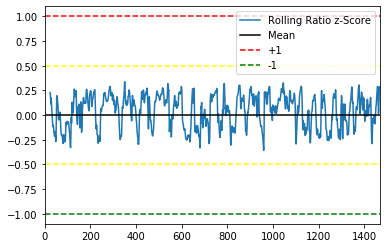

('banks\\INDUSINDBK.csv', 'banks\\SBIN.csv')


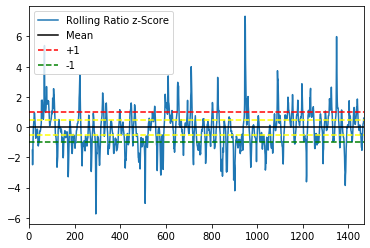

('banks\\J&KBANK.csv', 'banks\\KOTAKBANK.csv')
('banks\\J&KBANK.csv', 'banks\\PNB.csv')


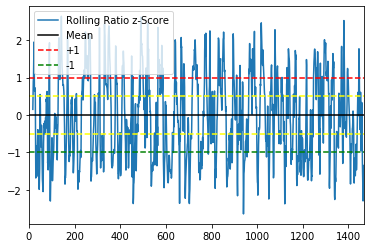

('banks\\J&KBANK.csv', 'banks\\SBIN.csv')
('banks\\KOTAKBANK.csv', 'banks\\PNB.csv')


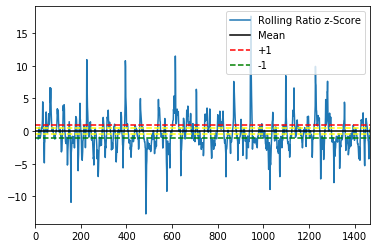

('banks\\KOTAKBANK.csv', 'banks\\SBIN.csv')
('banks\\PNB.csv', 'banks\\SBIN.csv')


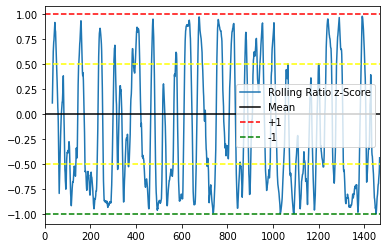

In [29]:
n = len(pairs)
for i in range(n): 
    print(pairs[i])
    plotter(pairs[i][0],pairs[i][1],windows[i])

('banks\\BANKBARODA.csv', 'banks\\SBIN.csv')


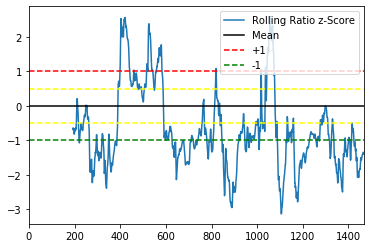

In [33]:
i = 16
print(pairs[i])
plotter(pairs[i][0],pairs[i][1],(0,159))

In [21]:
i = pairs[27]
print(i)
window_1 = optimal_window(i[0],i[1])
print('----')
trade1(i[0],i[1],window_1)
windows.append(window_1)

('banks\\HDFCBANK.csv', 'banks\\KOTAKBANK.csv')
5
(0, 5)
training13575.606169544677
Avg Return
10895.56653961579
10898.568073097811
----
Exit pos 10000.0 0.8614040429470311 0 0
1007.6011960000001
1169.719604
Exit pos 10000.0 0.8627179586384924 0 0
1012.242188
1173.317627
Exit pos 10000.0 0.8456470230730976 0 0
1039.036133
1228.6877439999998
Exit pos 10000.0 0.8385001587924368 0 0
1026.90271
1224.689941
Exit pos 10000.0 0.8525629873578163 0 0
1032.15332
1210.647583
Exit pos 10000.0 0.8077670654787932 0 0
1035.201416
1281.559326
Exit pos 10000.0 0.857691439807441 0 0
1027.0894779999999
1197.504639
Exit pos 10000.0 0.8296536257261817 0 0
1025.231201
1235.734009
1029.36084
1254.5738529999999
Buying Ratio 10000.0 0.8204864444915226 4.857383150499488 -3.9854170306863557
Exit pos 10174.218530642109 0.8494946716887734 0 0
1050.34375
1236.4335939999999
Exit pos 10174.218530642109 0.8492556907852022 0 0
1049.114624
1235.3342289999998
Exit pos 10174.218530642109 0.8462129991717912 0 0
1038.082397

In [25]:
i = pairs[27]
#print(i)
#window_1 = optimal_window(i[0],i[1])
print('----')
trade1(i[0],i[1],(0,5))
windows.append(window_1)

----
Exit pos 10000.0 0.7294335235294701 0 0
464.11770599999994
636.271423
Exit pos 10000.0 0.7274539948818429 0 0
474.978485
652.932678
Exit pos 10000.0 0.7287443804474323 0 0
477.71133399999997
655.526611
Exit pos 10000.0 0.7225922746060698 0 0
481.10391200000004
665.802734
Exit pos 10000.0 0.7370810014239034 0 0
478.653717
649.39093
Exit pos 10000.0 0.7344437532506681 0 0
483.38919100000004
658.170471
484.590637
641.259827
Selling Ratio 10000.0 0.7556853191116868 -10.31798722103663 7.797151465719371
Exit pos 10141.051924059784 0.7356410578818349 0 0
501.718292
682.015076
Exit pos 10141.051924059784 0.7428880842411067 0 0
504.73382599999997
679.4210820000001
Exit pos 10141.051924059784 0.7403277506672745 0 0
501.812531
677.824829
Exit pos 10141.051924059784 0.7356828287166775 0 0
503.838654
684.858521
Exit pos 10141.051924059784 0.7466044240583075 0 0
498.655518
667.897888
497.406921
661.612488
Selling Ratio 10141.051924059784 0.7518100550121418 -10.193919199668498 7.6638909542921025